In [33]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
total_epochs = 7

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=120000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df_all = df_all[df_all['time'] <= time_epoch * total_epochs]
df_all.index = df_all['time']
df_all.drop(columns=['time'],inplace=True)

In [34]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all['source computer'].values))) 

print('Testing a total of', len(hosts), 'hosts')

Testing a total of 1269 hosts


In [35]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df_all, size_of_bin_seconds=time_epoch,
                                                    doScale=True, addZeros=True, scaler='log', hosts=hosts, verbose=1)

A total of 7 time epochs have been encountered
Done with 0 hosts out of 1269
Done with 63 hosts out of 1269
Done with 126 hosts out of 1269
Done with 189 hosts out of 1269
Done with 252 hosts out of 1269
Done with 315 hosts out of 1269
Done with 378 hosts out of 1269
Done with 441 hosts out of 1269
Done with 504 hosts out of 1269
Done with 567 hosts out of 1269
Done with 630 hosts out of 1269
Done with 693 hosts out of 1269
Done with 756 hosts out of 1269
Done with 819 hosts out of 1269
Done with 882 hosts out of 1269
Done with 945 hosts out of 1269
Done with 1008 hosts out of 1269
Done with 1071 hosts out of 1269
Done with 1134 hosts out of 1269
Done with 1197 hosts out of 1269
Done with 1260 hosts out of 1269
Scaeling...


In [36]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus

In [37]:
number_of_mixtures = range(5,16)
update_powers = np.arange(0.1, 1.1, 0.1)

likelihoods = []

for mixtures in number_of_mixtures:

    kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=3000)
    
    # random initialization
    kplusplus.init_centers()

    for update_power in update_powers:
        onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 500, n_clusters=8, update_power=update_power)
        # ignore epoch index for now

        data = groupped_data.values[:,[0,1,3]]

        np.random.shuffle(data)


        onlineEM.fit(data)

        likelihood = onlineEM.calculate_likelihood(data[:,:2])
        likelihoods.append(likelihood)
        
        print('For number of mixtures', mixtures, 'and update_power', update_power, 'log likelihood is', likelihood)

For number of mixtures 5 and update_power 0.1 log likelihood is -38178.03474664777
For number of mixtures 5 and update_power 0.2 log likelihood is -38161.683250303795
For number of mixtures 5 and update_power 0.3 log likelihood is -38171.276862600214
For number of mixtures 5 and update_power 0.4 log likelihood is -38134.64214329028
For number of mixtures 5 and update_power 0.5 log likelihood is -38128.840088970304
For number of mixtures 5 and update_power 0.6 log likelihood is -38136.690505355
For number of mixtures 5 and update_power 0.7 log likelihood is -38573.805531509526
For number of mixtures 5 and update_power 0.8 log likelihood is -38571.89190847797
For number of mixtures 5 and update_power 0.9 log likelihood is -38558.27194820311
For number of mixtures 5 and update_power 1.0 log likelihood is -38824.359426200775
For number of mixtures 6 and update_power 0.1 log likelihood is -37944.09712786438
For number of mixtures 6 and update_power 0.2 log likelihood is -37830.73450194946
F

For number of mixtures 14 and update_power 0.9 log likelihood is -37709.84759522461
For number of mixtures 14 and update_power 1.0 log likelihood is -37766.90701781976
For number of mixtures 15 and update_power 0.1 log likelihood is -37694.88712401722
For number of mixtures 15 and update_power 0.2 log likelihood is -37730.313867384866
For number of mixtures 15 and update_power 0.3 log likelihood is -37713.8609047008
For number of mixtures 15 and update_power 0.4 log likelihood is -37620.61314002834
For number of mixtures 15 and update_power 0.5 log likelihood is -37671.64232071783
For number of mixtures 15 and update_power 0.6 log likelihood is -37667.80539678107
For number of mixtures 15 and update_power 0.7 log likelihood is -37649.45262547122
For number of mixtures 15 and update_power 0.8 log likelihood is -37676.42137654463
For number of mixtures 15 and update_power 0.9 log likelihood is -37702.23836072609
For number of mixtures 15 and update_power 1.0 log likelihood is -37755.3251

In [38]:
import numpy as np
np.set_printoptions(threshold=np.inf)

likelihoods = np.reshape(np.array(likelihoods), (len(number_of_mixtures), len(update_powers)))

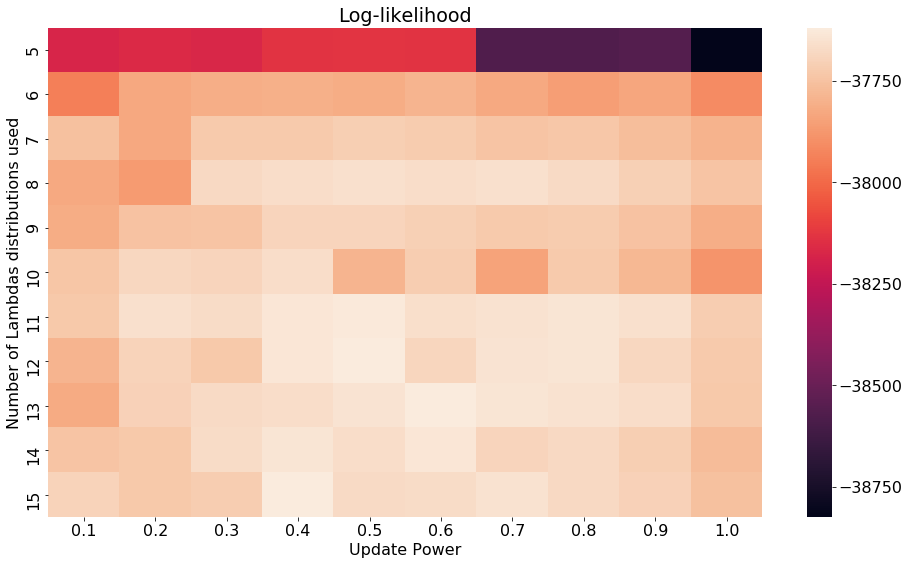

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

ax = sns.heatmap(likelihoods, xticklabels=update_powers, yticklabels=number_of_mixtures)
plt.ylabel('Number of Lambdas distributions used')
plt.xlabel('Update Power')
plt.title('Log-likelihood')
plt.show()

In [40]:
likelihoods

array([[-38178.03474665, -38161.6832503 , -38171.2768626 , -38134.64214329,
        -38128.84008897, -38136.69050535, -38573.80553151, -38571.89190848,
        -38558.2719482 , -38824.3594262 ],
       [-37944.09712786, -37830.73450195, -37811.2816096 , -37806.26874176,
        -37813.0128071 , -37792.61459406, -37823.26400458, -37855.84364351,
        -37831.49151965, -37908.03387808],
       [-37754.2581408 , -37830.83402852, -37726.83196625, -37723.38343937,
        -37711.91889562, -37718.42588746, -37744.50441564, -37735.06527732,
        -37764.71921786, -37794.91555844],
       [-37823.55213011, -37864.23460947, -37677.85061602, -37662.12065672,
        -37654.36607444, -37664.27105313, -37652.51331837, -37674.8953125 ,
        -37704.62971991, -37746.02574576],
       [-37814.66010897, -37749.61301692, -37744.7987392 , -37694.58164959,
        -37692.87866992, -37706.26381786, -37723.03896193, -37721.550579  ,
        -37748.91223752, -37808.92251094],
       [-37739.06423207, 